<font size="+3"><strong>Predicting House Prices with Size, Type and Neigborhood in Lagos State</strong></font>

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.utils.validation import check_is_fitted
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder # type: ignore
from sklearn.model_selection import train_test_split
import ipywidgets as widgets
from IPython.display import display


In this project, I will be working for a client who wants to create a model that can predict housing price in Lagos city of Nigeria — with a focus on apartments that cost less than ₦200,000,000.<span style='color: transparent; font-size:1%'>Taofeeq Nurudeen</span>

# 1.1 Prepare Data

Firstly, let's load our data

In [40]:
# Read csv file into dataframe
df = pd.read_csv("sale.csv")

# Drop prices greater than 200M in the data
price_mask = (df["Price"] < 200_000_000) & (df["Price"] > 1_000_000)
df = df[price_mask]

# Drop any NaN value in the data
df.dropna(inplace=True)
df.head()

,Unnamed: 0,Price,Pid,Property_name,Address,Neighboorhood
0,0,2500000,E9857,Land for sale Eleranigbe Eleranigbe Ibeju-Lekk...,Eleranigbe Eleranigbe Eleranigbe Ibeju-Lekki L...,Ibeju-Lekki
1,1,30000000,"17,H2630",667.0 square meter Land for sale opebi street ...,Opebi street opebi street Opebi Ikeja Lagos,Ikeja
4,4,28000000,G8554,3 bedroom Flat / Apartment for sale Igando Iko...,NEAR IGANDO B/STOP Igando Ikotun Igando Lagos,Igando
5,5,13000000,G5150,Land for sale Bucknor Isolo Lagos,Tijani Salako off Bode Shodiya street Bucknor ...,Isolo
6,6,12000000,G4891,1 bedroom mini flat Flat / Apartment for sale ...,"Fatade street, off Isheri/ Ijegun Rd, Kuduyeib...",Igando


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7822 entries, 0 to 9783
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     7822 non-null   int64 
 1   Price          7822 non-null   int64 
 2   Pid            7822 non-null   object
 3   Property_name  7822 non-null   object
 4   Address        7822 non-null   object
 5   Neighboorhood  7822 non-null   object
dtypes: int64(2), object(4)
memory usage: 427.8+ KB


I want to use size as a predictor for house prices but the dataset has mixed representations (e.g., numbers of bedrooms and square meter sizes), I need to transform the data into a uniform representation.

After checking the dataset carefully i got know that the dataset contains Land and houses. Since i will  be predicting house prices, i will need to only get obeservations that i am sure are houses

In [42]:
house_mask = df["Property_name"].str.contains("bedroom", case=False)
df = df[house_mask]
df

,Unnamed: 0,Price,Pid,Property_name,Address,Neighboorhood
4,4,28000000,G8554,3 bedroom Flat / Apartment for sale Igando Iko...,NEAR IGANDO B/STOP Igando Ikotun Igando Lagos,Igando
6,6,12000000,G4891,1 bedroom mini flat Flat / Apartment for sale ...,"Fatade street, off Isheri/ Ijegun Rd, Kuduyeib...",Igando
7,7,10000000,G4886,3 bedroom Bungalow for sale Abaranje Ikotun/Ig...,"Shodimu street by K& S B/stop, Abaranje Abaran...",Igando
9,9,30000000,H0634,3 bedroom Flat / Apartment for sale Oral Estat...,Oral Estate Oral Estate Ikota Lekki Lagos,Lekki
11,11,180000000,H3290,5 bedroom House for sale Lekki Phase 1 Lekki L...,Lekki Phase 1 Lekki Phase 1 Lekki Lagos,Lekki
...,...,...,...,...,...,...
9768,9768,170000000,E0755,3 bedroom Duplex for sale Old Ikoyi Ikoyi Lagos,Old ikoyi Old Ikoyi Ikoyi Lagos,Ikoyi
9769,9769,40000000,E0751,3 bedroom Duplex for sale Agungi Lekki Lagos,Off orchid road 2nd toll gate Agungi Lekki Lagos,Lekki
9779,9779,50000000,E0725,5 bedroom Duplex for sale Magodo Isheri Ojodu ...,"gateway zone, magodo Magodo Isheri Ojodu Lagos",Ojo
9780,9780,45000000,E0701,4 bedroom Duplex for sale Bakare Estate Agungi...,Sassi street Bakare Estate Agungi Lekki Lagos,Lekki


Now we need to extract our numbers of bedroom since our predictor is `size` and properties with more rooms tend to have larger sizes.

In [43]:
# Extract number of bedrooms from the description column
def extract_bedrooms(Property_name):
    match = re.search(r"(\d+)\s*bedroom", Property_name, re.IGNORECASE)
    if match:
        return int(match.group(1))
    return 0  # Return None if no match is found

# Apply the function to the column
df["bedrooms"] = df["Property_name"].apply(extract_bedrooms)
df.head()

,Unnamed: 0,Price,Pid,Property_name,Address,Neighboorhood,bedrooms
4,4,28000000,G8554,3 bedroom Flat / Apartment for sale Igando Iko...,NEAR IGANDO B/STOP Igando Ikotun Igando Lagos,Igando,3
6,6,12000000,G4891,1 bedroom mini flat Flat / Apartment for sale ...,"Fatade street, off Isheri/ Ijegun Rd, Kuduyeib...",Igando,1
7,7,10000000,G4886,3 bedroom Bungalow for sale Abaranje Ikotun/Ig...,"Shodimu street by K& S B/stop, Abaranje Abaran...",Igando,3
9,9,30000000,H0634,3 bedroom Flat / Apartment for sale Oral Estat...,Oral Estate Oral Estate Ikota Lekki Lagos,Lekki,3
11,11,180000000,H3290,5 bedroom House for sale Lekki Phase 1 Lekki L...,Lekki Phase 1 Lekki Phase 1 Lekki Lagos,Lekki,5


> Properties with more rooms generally tend to have larger sizes. However, this is not always true; for instance, a duplex with a smaller square meter size might have more rooms than a flat with a larger square meter size. To account for these differences in layout and space utilization, we will distinguish **flat** from **duplex** in our analysis.

In [44]:

df["type"] = df["Property_name"].apply(
    lambda property_name: "duplex" if "duplex" in property_name.lower() else "flat" 
)
# Drop any Nan column
df.dropna(inplace=True)
df

,Unnamed: 0,Price,Pid,Property_name,Address,Neighboorhood,bedrooms,type
4,4,28000000,G8554,3 bedroom Flat / Apartment for sale Igando Iko...,NEAR IGANDO B/STOP Igando Ikotun Igando Lagos,Igando,3,flat
6,6,12000000,G4891,1 bedroom mini flat Flat / Apartment for sale ...,"Fatade street, off Isheri/ Ijegun Rd, Kuduyeib...",Igando,1,flat
7,7,10000000,G4886,3 bedroom Bungalow for sale Abaranje Ikotun/Ig...,"Shodimu street by K& S B/stop, Abaranje Abaran...",Igando,3,flat
9,9,30000000,H0634,3 bedroom Flat / Apartment for sale Oral Estat...,Oral Estate Oral Estate Ikota Lekki Lagos,Lekki,3,flat
11,11,180000000,H3290,5 bedroom House for sale Lekki Phase 1 Lekki L...,Lekki Phase 1 Lekki Phase 1 Lekki Lagos,Lekki,5,flat
...,...,...,...,...,...,...,...,...
9768,9768,170000000,E0755,3 bedroom Duplex for sale Old Ikoyi Ikoyi Lagos,Old ikoyi Old Ikoyi Ikoyi Lagos,Ikoyi,3,duplex
9769,9769,40000000,E0751,3 bedroom Duplex for sale Agungi Lekki Lagos,Off orchid road 2nd toll gate Agungi Lekki Lagos,Lekki,3,duplex
9779,9779,50000000,E0725,5 bedroom Duplex for sale Magodo Isheri Ojodu ...,"gateway zone, magodo Magodo Isheri Ojodu Lagos",Ojo,5,duplex
9780,9780,45000000,E0701,4 bedroom Duplex for sale Bakare Estate Agungi...,Sassi street Bakare Estate Agungi Lekki Lagos,Lekki,4,duplex


#### High and Low cardinality fearures

Lastly, the features that have low and high cardinality need to be dropped as they will affect our model later

In [45]:
df.nunique()

Unnamed: 0       4773
Price             206
Pid              4773
Property_name    2650
Address          3600
Neighboorhood      41
bedrooms           10
type                2
dtype: int64

The above features with high cardinality (`Pid`, `Property_name`and `Address`) need to be dropped 

In [46]:
# Drop low and high cadinarlity categorical features
df.drop(["Pid", "Property_name", "Address", "Unnamed: 0"], axis="columns", inplace=True)

In [47]:
df

,Price,Neighboorhood,bedrooms,type
4,28000000,Igando,3,flat
6,12000000,Igando,1,flat
7,10000000,Igando,3,flat
9,30000000,Lekki,3,flat
11,180000000,Lekki,5,flat
...,...,...,...,...
9768,170000000,Ikoyi,3,duplex
9769,40000000,Lekki,3,duplex
9779,50000000,Ojo,5,duplex
9780,45000000,Lekki,4,duplex


#### Organizing the cleaning process

In order to make my analysis to be easily reproducible i will create a wrangle **function** for importing and cleaning the data. This will make sure that all our data undergoes the same process.

In [48]:
# Let's put the the cleaning into this function

def wrangle(filepath: str):
    # Read csv file into dataframe
    df = pd.read_csv(filepath)
    
    # Let's get only houses that are less than 200M
    price_mask = (df["Price"] < 200_000_000) & (df["Price"] > 1_000_000)
    df = df[price_mask]
    
    # Since our data contain Land and houses let get only the houses
    house_mask = df["Property_name"].str.contains("bedroom", case=False)
    df = df[house_mask]
    
    # Extract number of bedrooms from the description column
    def extract_bedrooms(Property_name):
        match = re.search(r"(\d+)\s*bedroom", Property_name, re.IGNORECASE)
        if match:
            return int(match.group(1))
        return 0  # Return None if no match is found

    # Apply the function to the column
    df["bedrooms"] = df["Property_name"].apply(extract_bedrooms)
        
    # Distinguish between flat and duplex
    df["type"] = df["Property_name"].apply(
        lambda property_name: "duplex" if "duplex" in property_name.lower() else "flat" 
    )
    
    # Drop low and high cadinarlity categorical features
    df.drop(["Pid", "Property_name", "Address", "Unnamed: 0"], axis="columns", inplace=True)
    
    # Drop any Nan column and reset index
    df.dropna(inplace=True)
    df.reset_index(inplace=True)
    df.drop(["index"], axis="columns", inplace=True)
    
    # return cleaned data
    return df

In [49]:
# Let's use the wrangle function

df = wrangle(filepath="sale.csv")

In [50]:
df

,Price,Neighboorhood,bedrooms,type
0,28000000,Igando,3,flat
1,12000000,Igando,1,flat
2,10000000,Igando,3,flat
3,30000000,Lekki,3,flat
4,180000000,Lekki,5,flat
...,...,...,...,...
4768,170000000,Ikoyi,3,duplex
4769,40000000,Lekki,3,duplex
4770,50000000,Ojo,5,duplex
4771,45000000,Lekki,4,duplex


Property size is an important factor in determining price. With that in mind, let's look at the distribution of houses sizes in our dataset. But in our case no. of bedrooms

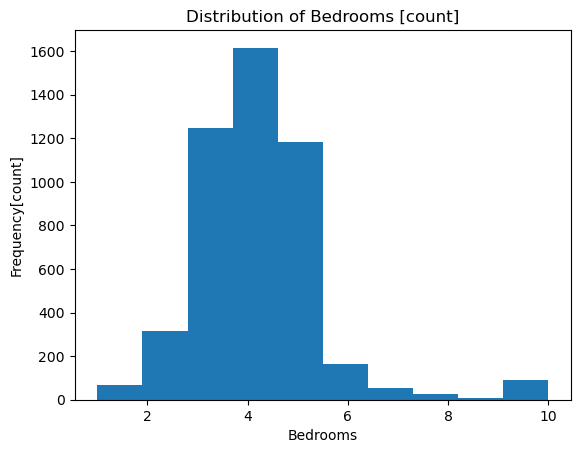

In [51]:
plt.hist(df["bedrooms"])
plt.xlabel("Bedrooms")
plt.ylabel("Frequency[count]")
plt.title("Distribution of Bedrooms [count]");

> The above histogram shows that most houses in lagos are 3 to 5 bedrooms apartment

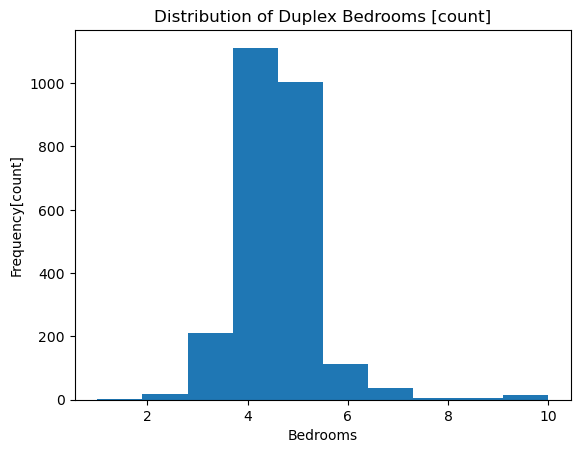

In [52]:
mask = df["type"] == "duplex"
plt.hist(df[mask]["bedrooms"])
plt.xlabel("Bedrooms")
plt.ylabel("Frequency[count]")
plt.title("Distribution of Duplex Bedrooms [count]");

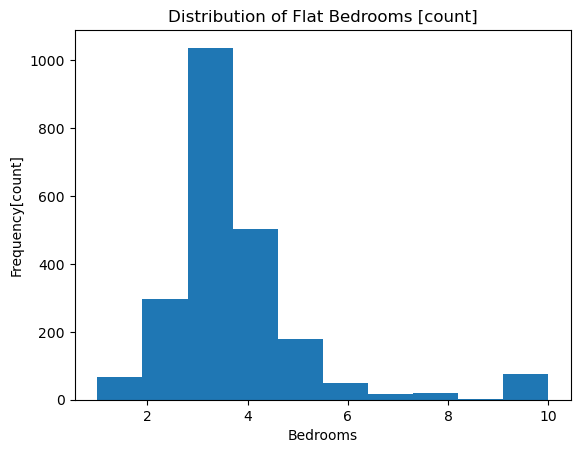

In [53]:
mask = df["type"] == "flat"
plt.hist(df[mask]["bedrooms"])
plt.xlabel("Bedrooms")
plt.ylabel("Frequency[count]")
plt.title("Distribution of Flat Bedrooms [count]");

> This histogram provides an overview of the bedroom size distribution of both duplex and flat and can be useful in understanding the typical size of properties within this dataset.

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4773 entries, 0 to 4772
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Price          4773 non-null   int64 
 1   Neighboorhood  4773 non-null   object
 2   bedrooms       4773 non-null   int64 
 3   type           4773 non-null   object
dtypes: int64(2), object(2)
memory usage: 149.3+ KB


In [55]:
df["Price"].describe()

count    4.773000e+03
mean     6.317160e+07
std      4.171498e+07
min      1.200000e+06
25%      3.500000e+07
50%      5.500000e+07
75%      8.000000e+07
max      1.990000e+08
Name: Price, dtype: float64

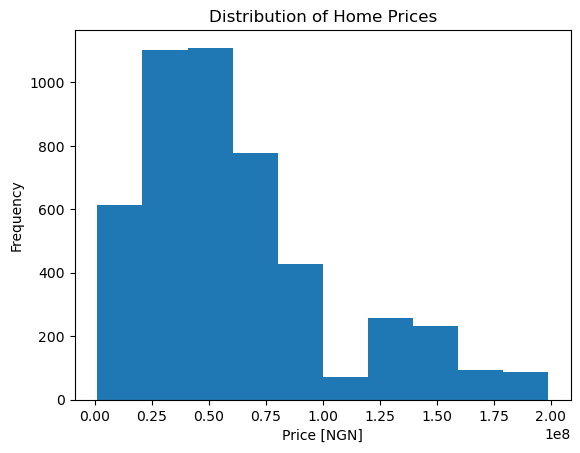

In [56]:
plt.hist(df["Price"], bins=10)
plt.xlabel("Price [NGN]")
plt.ylabel("Frequency")
plt.title("Distribution of Home Prices");

##### **Key Observations:**

- **Skewed Distribution:** The histogram is right-skewed (positively skewed), meaning that most of the homes in the dataset have a lower price (closer to 1M NGN), and fewer homes are priced in the higher ranges.

- **Price Concentration:** The highest frequency of homes falls within the price range of 1 to 75 million NGN, with a peak around 50 million NGN. This suggests that there is a higher concentration of more affordable homes in the dataset.

- **Decreasing Frequency with Higher Prices:** As the price increases, the frequency of homes in higher price ranges decreases. The lower bars around 1 million NGN and above indicate fewer homes in this price range.

##### Conclusion
- This distribution implies that the majority of homes in the dataset are priced at lower amounts, with a smaller number of homes having very high prices.

- The data might represent a typical housing market where affordable properties are more common than luxury or high-priced homes.

Let's plot a scatter plot to show the relationship between house `prices` and `no. of bedrooms`

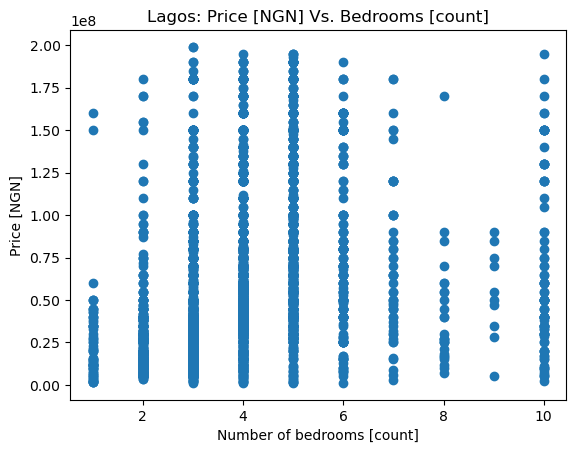

In [57]:
plt.scatter(x=df["bedrooms"], y=df["Price"])
plt.xlabel("Number of bedrooms [count]")
plt.ylabel("Price [NGN]")
plt.title("Lagos: Price [NGN] Vs. Bedrooms [count]");

The scatter suggests that there is a clustering of house prices at specific values for each number of bedrooms, creating vertical bands or columns in the plot. This could be caused by:

- **Discrete Price Ranges:** Properties with the same number of bedrooms may have similar or identical prices, leading to clustering at those price points.

- **Price Categories:** The market may have price categories or specific pricing structures that group homes with similar features (e.g., number of bedrooms) into distinct price ranges.

Let's check the correlation between house `prices` and `numbers of bedrooms`

In [58]:
# Let's check the correlation
df["Price"].corr(df["bedrooms"])

0.31452659738248917

> A correlation value of 0.314 between the number of `bedrooms` and house `prices` indicates a weak positive correlation. Here's what this means:

**Interpretation:**
- **Weak Positive Correlation:** The correlation coefficient is between 0.3 and 0.5, which indicates a weak but positive relationship between the two variables. As the number of bedrooms increases, house prices tend to increase slightly, but the relationship is not strong.

    - A correlation of 0.314 suggests that number of bedrooms is a somewhat predictive factor for house prices, but there are likely other factors (e.g., property location, size, type, etc.) that play a more significant role in determining the price.

##### **Group By Property Type**

Let's see if property type influence house price

In [59]:
# Group by Property_Type and calculate mean price for each type
property_type_price = df.groupby('type')['Price'].mean()
print(property_type_price)

type
duplex    7.649430e+07
flat      4.821986e+07
Name: Price, dtype: float64


**Interpretation:**

- Duplex: The average price is approximately 76.5 million NGN.
- Flat: The average price is approximately 48.2 million NGN.

Duplex properties generally have higher average prices than flat properties in your dataset.
The difference in average prices suggests that duplexes tend to be more expensive, which is typical, as duplex homes are usually larger or more luxurious compared to flats (apartments).

##### Boxplot for Price by House Type:


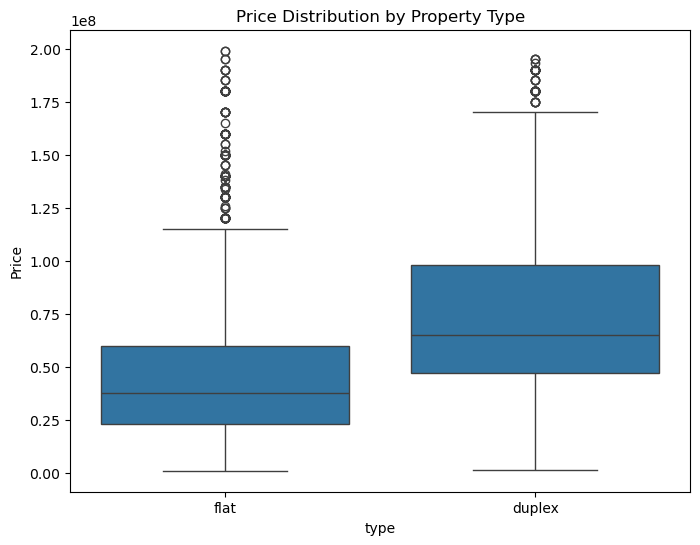

In [60]:
# Create a boxplot to visualize price distribution by property type
plt.figure(figsize=(8, 6))
sns.boxplot(x='type', y='Price', data=df)
plt.title('Price Distribution by Property Type')
plt.show()

**Insights:**
- Duplexes tend to be priced higher than flats, with a wider spread of prices.
- Flats have many high-price outliers, which might indicate a few very expensive flats skewing the data.

##### **Group By Neigbourhood:**

In [61]:
# Group by Location and calculate mean price for each location
neigbourhood_price = df.groupby('Neighboorhood')['Price'].mean()
neigbourhood_price.head(20)

Neighboorhood
Abule-Egba      3.402604e+07
Agege           4.029412e+07
Ajah            4.888797e+07
Alapere         2.448077e+07
Alimosho        3.786719e+07
Amuwo-Odofin    5.923830e+07
Apapa           4.416667e+07
Badagry         2.250000e+07
Bariga          5.709091e+07
Ejigbo          2.835714e+07
Epe             4.250000e+07
Gbagada         6.131183e+07
Ibeju-Lekki     3.182558e+07
Idimu           3.127000e+07
Ifako-Ijaiye    3.500000e+07
Igando          3.108667e+07
Ijora           7.500000e+07
Ikeja           9.851341e+07
Ikorodu         2.248102e+07
Ikosi           6.312500e+07
Name: Price, dtype: float64

> Let's sort the `neigbourhood_price` and get the top 15 neigbourhood with high housing market 

In [62]:
neigbourhood_price = neigbourhood_price.sort_values(ascending=False).head(15)

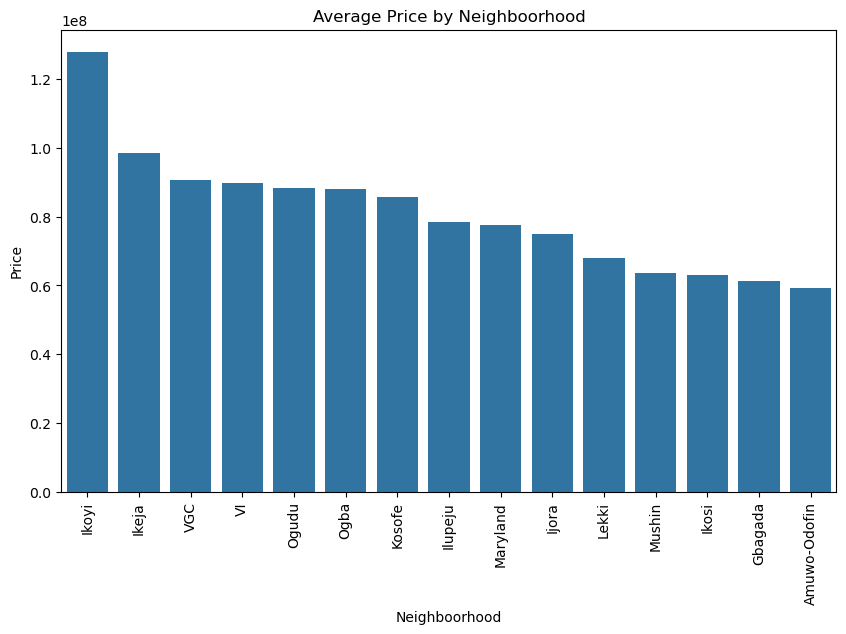

In [63]:
plt.figure(figsize=(10, 6))
sns.barplot(data=neigbourhood_price)
plt.title('Average Price by Neighboorhood')
plt.xticks(rotation=90)
plt.show()

> The above plot shows 15 high Lagos housing market neigbourhood with **IKOYI** as the highest


## Split

At this point, the feature matrix `X_train` and target vector `y_train` will be created. The target is `"Price"`. The features should be all the columns that remain in the DataFrame you cleaned above.you

In [64]:
target = "Price"
y = df[target]
X = df.drop([target], axis="columns")

print(y.shape)
print(X.shape)

(4773,)
(4773, 3)


 The data (X and y) need to be divided into training and test sets using a randomized train-test split. The test will should be 20% of the total data. And random_state will be set to 42 for reproducibility.

In [65]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (3818, 3)
y_train shape: (3818,)
X_test shape: (955, 3)
y_test shape: (955,)


# Build Model

## Baseline

In [66]:
y_mean = y_train.mean() 
y_pred_baseline = [y_mean] * len(y_train)

In [67]:
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)

print("Mean apt price:", y_mean)

print("Baseline MAE:", mae_baseline)

Mean apt price: 63266456.86432687
Baseline MAE: 32493919.915718906


## Iterate

The next step is to create a pipeline whcih will include **OneHotEncoder** for transforming no-numerical features and **LinerRegresssion** as predictor. Then fit the model to the training data.

In [68]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    Ridge()
)

model.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Neighboorhood', 'type'],
                               use_cat_names=True)),
                ('ridge', Ridge())])

In [69]:
# Check your work
check_is_fitted(model[-1])# Check your work

Wow, a model with transformer and a predictor has just been built! 😁

Calculating the training mean absolute error for the predictions as compared to the true targets in `y_train`.

In [70]:
y_pred_training = model.predict(X_train)
mean_training = mean_absolute_error(y_train, y_pred_training)

print("Training MAE: ", round(mean_training, 2))

Training MAE:  23202600.67


<div class="alert alert-block alert-success">
Good news: Our model beat the baseline by over ₦10,000,000! That's a good indicator that it will be helpful in predicting housing price. But the real test is how the model performs on data that it hasn't seen before, data that we call the <b>test set</b>. Let see how the model will perform with the test set. 
</div>

## Evaluate

In [71]:
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    4.334217e+07
1    5.010920e+07
2    1.419452e+08
3    7.350242e+07
4    1.899021e+07
dtype: float64

# Communicate Results

The model is now built and tested, it's time to share it with others. If you're presenting to simple linear model to a technical audience, they might appreciate an equation. When we created our baseline model, we represented it as a line. The equation for a line like this is usually written as:

Extract the intercept and coefficients for your model. 

In [72]:
intercept = model.named_steps["ridge"].intercept_.round()
coefficients = model.named_steps["ridge"].coef_.round()


print(intercept)
coefficients

24108183.0


array([ 23520691.,  -5799637.,  10519056.,  -6301059.,  34370943.,
       -26562099.,  80110577., -28723139.,  -7617318., -16791758.,
        25840257.,   3752029.,  37402718.,    919295., -30051268.,
         8067666.,  -3091306., -29669677., -18478929.,   4941176.,
        21579641.,   4066547., -34301000.,  -6144910., -12364620.,
        19128465.,  41767579.,  20285123.,  -6899626., -28087844.,
       -30580008., -12998721., -10176567.,   1844013., -21809422.,
        -5201936.,   8776889.,  -9610406.,  -7141603.,  11510187.,
         7601206.,   7321660.,  -7321660.])

Le't wrap the model in a function so that a developer can provide inputs and then receive a prediction as output. 

The function will be named `make_prediction` and will take four arguments (`type`, `bedrooms`, and `neighborhood`) and returns your model's prediction for an house price.

In [73]:
df.columns

Index(['Price', 'Neighboorhood', 'bedrooms', 'type'], dtype='object')

In [74]:
def make_prediction(neigbourhood: str, bedrooms: int, type: str):
    data = pd.DataFrame({
            "Neighboorhood" : neigbourhood,
            "bedrooms" : bedrooms,
            "type" : type,
        }, index = [0])
    prediction = model.predict(data)
    return f"₦{round(prediction[0]):,}"

Let's test the function

In [75]:
make_prediction(neigbourhood="Ikoyi", bedrooms=4, type="duplex")

'₦141,945,244'

> Below is an interactive dashboard created using [Jupyter Widgets], where a user can supply values and receive a prediction.

In [84]:
# Title for the application
title = widgets.HTML(
    value="<h1 style='text-align:left; font-size:32px;'>Lagos Housing Price Predictor</h1>"
)

# Radio Buttons for Property Type
property_type_radio = widgets.RadioButtons(
    options={'Flat' : 'flat', 'Duplex' : 'duplex'},
    value='flat',  # Default selection
    description='Property Type:',
    style={'description_width': 'initial'},  # Aligns description properly
    layout=widgets.Layout(width='50%')
)

# Dropdown for Neighborhood
neighborhood_dropdown = widgets.Dropdown(
    options=sorted(X_train["Neighboorhood"].unique()),
    value='Ikoyi',  # Default selection
    description='Neighborhood:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

# Slider for Number of Bedrooms
bedroom_slider = widgets.IntSlider(
    value=3,  # Default selection
    min=1,
    max=20,
    step=1,
    description='Bedrooms:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

# Ouput
text_output = widgets.Text(
    value='',
    description='House Price Prediction:',
    disabled=False,
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='50%')
)

# Function to update the output based on widget changes
def update_values(change):
    # Get current values from widgets
    neighborhood = neighborhood_dropdown.value
    bedrooms = bedroom_slider.value
    property_type = property_type_radio.value

    # Call the make_prediction function and display the predicted price
    predicted_price = make_prediction(neighborhood, bedrooms, property_type)
    text_output.value = predicted_price
    # with output:
    #     print(f"Property Type: {property_type_radio.value}")
    #     print(f"Neighborhood: {neighborhood_dropdown.value}")
    #     print(f"Bedrooms: {bedroom_slider.value}")


# Observe changes in the widgets and update the output
property_type_radio.observe(update_values, names='value')
neighborhood_dropdown.observe(update_values, names='value')
bedroom_slider.observe(update_values, names='value')


# Real-time value output widget
# output = widgets.Output()

# Display Widgets
display(title)
display(property_type_radio)
display(widgets.HTML("<br>"))
display(neighborhood_dropdown)
display(widgets.HTML("<br>"))
display(bedroom_slider)
display(widgets.HTML("<br>"))
display(text_output)
display(widgets.HTML("<br>"))
update_values("")



HTML(value="<h1 style='text-align:left; font-size:32px;'>Lagos Housing Price Predictor</h1>")

RadioButtons(description='Property Type:', layout=Layout(width='50%'), options={'Flat': 'flat', 'Duplex': 'dup…

HTML(value='<br>')

Dropdown(description='Neighborhood:', index=19, layout=Layout(width='50%'), options=('Abule-Egba', 'Agege', 'A…

HTML(value='<br>')

IntSlider(value=3, description='Bedrooms:', layout=Layout(width='50%'), max=20, min=1, style=SliderStyle(descr…

HTML(value='<br>')

Text(value='', description='House Price Prediction:', layout=Layout(width='50%'), style=TextStyle(description_…

HTML(value='<br>')